**[Day4]**  24.3.25.월

<small>6.1.4 (214p) ~ 7.5 (267p)<small>

6장. 신경망을 활용한 데이터 적합

6.1 인공뉴런

6.1.2 오차함수

6.1.3 우리에게 필요한건 활성함수

6.1.4 그밖의 활성함수


6.2 파이토치 


In [3]:
#-CH5 코드 재입력-
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

C = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] #t_c = C
U = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] #t_u = U
C = torch.tensor(C).unsqueeze(1) # <1>
U = torch.tensor(U).unsqueeze(1) # <1>

U.shape



n_samples = U.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices



train_U = U[train_indices]
train_C = C[train_indices]

val_U = U[val_indices]
val_C = C[val_indices]

train_Un = 0.1 * train_U
val_Un = 0.1 * val_U



6.2.1 forward 대신 __call__ 사용하기

6.2.2 다시 선형 모델로

In [4]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) #nn.Linear : 가중치와 편향을 무작위로 초기화함
linear_model(val_Un)

tensor([[0.2194],
        [0.3329]], grad_fn=<AddmmBackward0>)

In [5]:
linear_model.weight

Parameter containing:
tensor([[0.0479]], requires_grad=True)

In [6]:
linear_model.bias

Parameter containing:
tensor([-0.0593], requires_grad=True)

In [7]:
#입력값으로 모듈 호출
x = torch.ones(1)
linear_model(x)

tensor([-0.0114], grad_fn=<ViewBackward0>)

<배치 입력 만들기>

In [8]:
x = torch.ones(10,1)
linear_model(x)

tensor([[-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114],
        [-0.0114]], grad_fn=<AddmmBackward0>)

<배치 최적화>

In [9]:
C = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] 
U = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
C = torch.tensor(C).unsqueeze(1)
U = torch.tensor(U).unsqueeze(1)

U.shape

torch.Size([11, 1])

In [10]:
#학습코드 업데이트
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(
    linear_model.parameters(), #params대신 넣은것
    lr=1e-2)

In [11]:
#parametes메소드 호출을 통해 모든 파라미터 리스트를 담은 리스트 반환함. 
linear_model.parameters() 

<generator object Module.parameters at 0x000002ADC2557580>

In [12]:
#파라미터 리스트 얻을 수 있음~
list(linear_model.parameters())
#결과: 첫번쨰 텐서: w / 두번쨰 : b

[Parameter containing:
 tensor([[-0.2832]], requires_grad=True),
 Parameter containing:
 tensor([0.3219], requires_grad=True)]

In [13]:
#훈련루프 정의
#optimizer.step()을 호출해 각 파라미터 순회하며 grad속성에 저장된 비율만큼 값 조정함. 
def training_loop(n_epochs, optimizer, model, loss_fn, train_U, val_U,
                  train_C, val_C):
    for epoch in range(1, n_epochs + 1): 
        train_P = model(train_U) #()안을 모델에 입력해 train_P계산=학습데이터에 대한 모델의 예측값
        loss_train = loss_fn(train_P, train_C) #손실함수로 진치

        val_P = model(val_U)
        loss_val = loss_fn(val_P, val_C)



        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()


        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")      

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), #손실함수는 그동안처럼 직접 만드는게 아니고, 이렇게 불러오는거~
    train_U = train_Un,
    val_U = val_Un,
    train_C = train_C,
    val_C = val_C)

print()
print(linear_model.weight)
print(linear_model.bias)

#list(linear_model.parameters()) #위의 프린트 구문이랑 같은거~~ 이건 인덱스로 엑세스/ print는 값 직접 출력

Epoch 1, Training loss 81.0036, Validation loss 383.0427
Epoch 1000, Training loss 4.0285, Validation loss 14.2342
Epoch 2000, Training loss 3.0244, Validation loss 6.7294
Epoch 3000, Training loss 2.9751, Validation loss 5.4654

Parameter containing:
tensor([[5.0048]], requires_grad=True)
Parameter containing:
tensor([-15.8261], requires_grad=True)


6.3 드디어 신경망!

In [15]:
#nn.Sequential 컨테이너를 통해 모듈을 간단히 결합
seq_model = nn.Sequential( #여러 layer정의
            nn.Linear(1, 13), #첫번째층. 입력1차원, 출력13차원(fully connected)
            nn.Tanh(), #두번쨰층. 활성화함수 적용
            nn.Linear(13, 1)) #3번째층. 입력13, 출력1차원
seq_model  #해당 신경망의 구조 요약해 확인 가능


Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

6.3.2 파라미터 살펴보기
-------------------------

In [16]:
#파라미터 보기 위해 차원 정보 출력하기
#출력 : 앞으로 최적화 함수로 전달될 텐서임
[param.shape for param in seq_model.parameters()]

#list comprehension(리스트 내포): 반복문으로 리스트를 생성. 여기선 각 파라미터의 shape를 리스트로 출력함. 

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

*파라미터에 이름 붙여주기 2가지 방법

In [17]:
#1안. 파라미터에 이름 붙여주기
for name, param in seq_model.named_parameters():
    print(name, param.shape)
#결과 앞의 숫자: layer 층 번호임

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
#2안. OrderDict라는 sequentioal인자에 각 모듈의 이름을 정해서 전달
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activtion', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activtion): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)
#결과: 2안에서 붙인 이름을 1안 형태로 출력

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [20]:
#특정 parameter에 접근하기
seq_model.output_linear.bias

Parameter containing:
tensor([0.0884], requires_grad=True)

In [21]:
#train하는동안 기울기 모니터링하는데 응용~
#은닉층의 선형 영역에서 weight의 기울기 출력/ 마지막 에포크 후 기울기 보면 됌
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    train_U = train_Un,
    val_U = val_Un, 
    train_C = train_C,
    val_C = val_C)

print('output', seq_model(val_Un))
print('answer', val_C)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 108.9966, Validation loss 482.6828


Epoch 1000, Training loss 4.9021, Validation loss 55.9088
Epoch 2000, Training loss 3.0818, Validation loss 28.2899
Epoch 3000, Training loss 2.5499, Validation loss 18.2737
Epoch 4000, Training loss 2.2576, Validation loss 13.0866
Epoch 5000, Training loss 2.0662, Validation loss 9.7559
output tensor([[13.3619],
        [23.8984]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [28.]])
hidden tensor([[-0.0359],
        [-0.0185],
        [-0.1148],
        [ 0.0317],
        [ 0.0177],
        [ 0.0148],
        [ 0.0118],
        [-0.0141]])


6.3.3 선형 모델과 비교하기
-----------

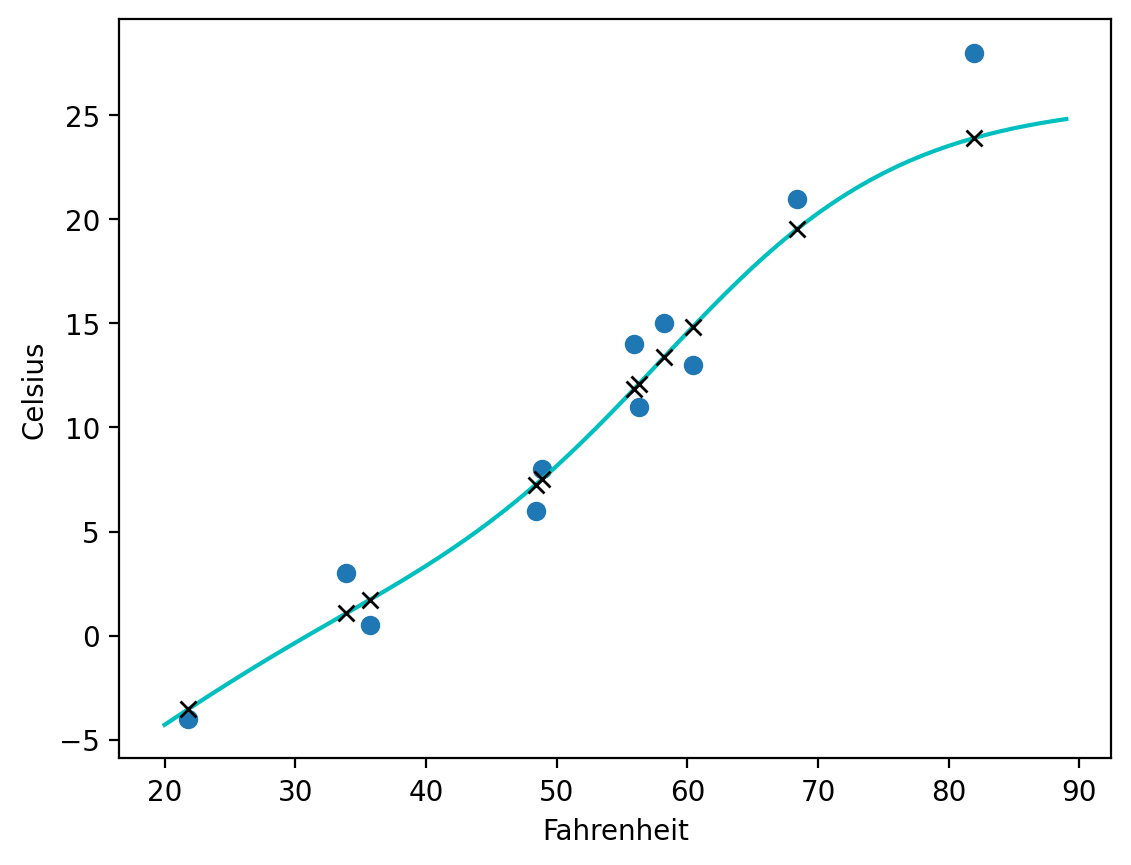

In [22]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=200)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(U.numpy(), C.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(U.numpy(), seq_model(0.1 * U).detach().numpy(), 'kx')


7장. 새와 비행기 구별하기: 이미지학습
=============

In [23]:
#기본 코드 가져온거
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)



In [24]:
!pip install torchvision

In [25]:
from torchvision import datasets #이걸로 컴퓨터 비전 데이터셋들 접근 가능~ #torch.utils.data.Dataset의 서브클래스로 반환됨
data_path = '../data-unversioned/p1ch7/' #저장 경로 지정
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # 
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # val데이터 by train=False

Files already downloaded and verified
Files already downloaded and verified


In [26]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

7.1.2 데이터셋 클래스
------------

In [27]:
#데이터셋 아이템 수 반환
len(cifar10)

50000

In [28]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

img, label = cifar10[99] #cifar10리스트의 100번째 요소 참조
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

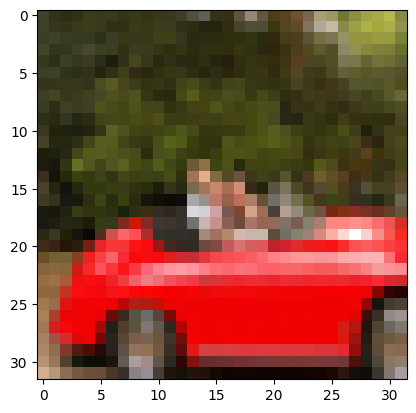

In [29]:
#이미지 열어보기
plt.imshow(img) #이미지 플로팅함. img= 배열or 이미지 객체 // 주피터랩에서는 이것만 있어도 보임~~
plt.show() #실제 표시 

7.1.3 데이터 변환
-------------

In [30]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [31]:
#1안. ToTensor
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape #>>>정수값 가짐

torch.Size([3, 32, 32])

In [32]:
#2안. ToTensor를 datasets.CIFAR10의 인자로 전달 가능.
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [33]:
#이미지가 아닌 텐서로 변환됐는지 확인
img_t, _ = tensor_cifar10[99] #, _ : 다른 정보를 사용하지 않겠다~~
type(img_t)

torch.Tensor

In [34]:
img_t.shape, img_t.dtype  

(torch.Size([3, 32, 32]), torch.float32)

In [35]:
#pil이미지 값: 0~255 / ToTensor : 0.0~1.0
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

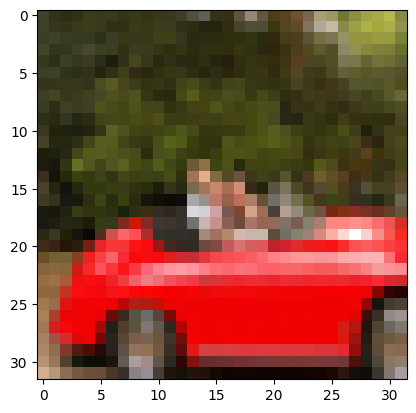

In [36]:
plt.imshow(img_t.permute(1, 2, 0)) #permute: 텐서차원 재배열 (너비, 채널, 높이)
plt.show()

7.1.4 데이터 정규화
---------------

by transforms.Normalize

In [37]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3) #torch.stack: cifar10에서 추출한 이미지들을 쌓아 새로운 텐서 생성
#dim: 어느 차원에 이미지 쌓을지~
imgs.shape

torch.Size([3, 32, 32, 50000])

In [38]:
#<채널별 평균계산>
imgs.view(3, -1).mean(dim=1)
#>> 3, -1 : 채널은 유지하되, 나머지 차원을 하나로 합쳐라. => 32*32= 1024 => 각 채널의 1024개 요소에 대해 계산함
#mean(dim=1) : rgb 각 채널에 대한 평균 계산 및 반환

tensor([0.4914, 0.4822, 0.4465])

In [39]:
#<채널별 표준편차 계산>
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [40]:
#노멀라이즈 진행~
transforms.Normalize(0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)

(Normalize(mean=0.4915, std=0.4823), (0.247, 0.2435, 0.2616))

In [41]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), 
                             (0.2470, 0.2435, 0.2616))    
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


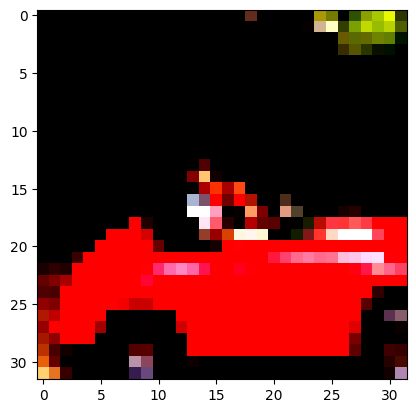

In [42]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

7.2 새와 비행기를 구별하기
-----------------------

7.2.1 데이터셋 구축

In [43]:
#새와 비행기만 들어간 dataset subclass만들기
label_map = {0: 0, 2: 1} #[cifar10 : cifar2] / 레이블을 cifar10에서 2인걸 cifar2에서는 1로 변경하라. 
class_names = ['airplane', 'bird'] 

#if문에 해당하면 cifar10에서 img, label을 튜플 형태((img, label_map[label]))로 리스트에 추가해라. 
cifar2 = [(img, label_map[label])   for img, label in cifar10
                                        if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

7.2.2 완전 연결 모델
--------------

In [44]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(             #****고수는 이렇게 입력, 출력 한줄씩 적음
            nn.Linear(
                3072, #입력 피처
                512,  #다음 layer에 전달되는 피처
            ),
            nn.Tanh(),
            nn.Linear(
                512,
                n_out,  #출력 클래스 / 위에서 지정한 2
            )
        )

7.2.3 분류기의 출력
--------------

7.2.4 출력을 확률로 표현하기
--------------


In [45]:
#소프트맥스 : 지수연산 후 각 요소를 지수의 총합으로 나누기
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum() #exp(x) = e의 x승 **exp = 지수함수

In [46]:
#test
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [47]:
softmax(x).sum()

tensor(1.)

In [48]:
#softmax 모듈처럼 사용해보기~
softmax = nn.Softmax(dim=1) #각 행에 대해 softmax를 계산한거임

x = torch.tensor([[1.0, 2.0, 3.0],     
                  [1.0, 2.0, 3.0]])

softmax(x)  #그냥 텐서는 그대론데 각 값이 해당 행의 softmax로 변환된거임

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [49]:
model = nn.Sequential(
           nn.Linear(3072, 512),
           nn.Tanh(),
           nn.Linear(512, 2), 
           nn.Softmax(dim=1))   #마지막에 softmax추가~

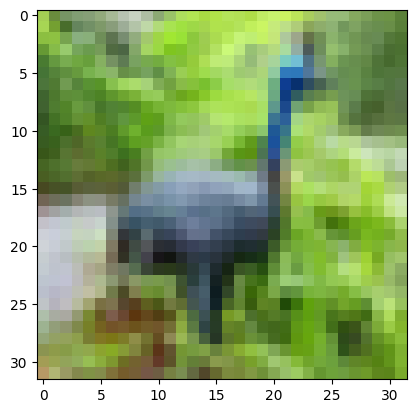

In [50]:
#훈련전에 이미지 하나 넣고 돌려보쟝~
img, _ = cifar2[0]

transform = transforms.ToTensor()
img = transform(img)

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [51]:
img_batch = img.view(-1).unsqueeze(0)

In [52]:
out = model(img_batch)
out

tensor([[0.4091, 0.5909]], grad_fn=<SoftmaxBackward0>)

In [53]:
_, index = torch.max(out, dim=1) #torch.max : 각 행 또는 열의 최대값 찾음

index

tensor([1])

7.2.5 분류를 위한 손실값
-------------------

In [54]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2), 
            nn.LogSoftmax(dim=1)) 

In [55]:
#NLL손실값 초기화
loss = nn.NLLLoss()

In [58]:
#test
img, label = cifar2[0]

transform = transforms.ToTensor()
img = transform(img)

out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))


tensor(0.7276, grad_fn=<NllLossBackward0>)

7.2.6 분류기 훈련
---------